# Figure showing pre-processing steps for the SA.

Sequential method pre-processing. The figure contains the following panels:

* Panel A -- flow chart: Leiden clustering, consensus, stan fits 
* Panel B -- heatmap: MFI for the different clusters
* Panel C -- UMAP showing the clusters
* Panel D -- cell density UMAP, split per day to show time evolution
* Panel E -- frequency timecourses

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import json
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib

import scdynsys.plots as plots
import scdynsys.utilities as utils
from scdynsys.projection import O2_transform

tex_fonts = {
    "font.family" : "Helvetica",
    'pdf.fonttype' : 42,
}

plt.rcParams.update(tex_fonts)

tabcolors =  [matplotlib.colors.to_hex(plt.cm.tab20(i/20)) for i in range(20)]
tabcolors = [tabcolors[2*i] for i in range(10)] + [tabcolors[2*i+1] for i in range(10)]

### Create a figure object and grid

We will construct the figure using multiple cells in the notebook.

In [2]:
gs = GridSpec(5, 8) ## CD8 with 8 clusters

fig = plt.figure(figsize=(14, 10)) ## CD8

labx, laby = -0.05, 1.05

fig.subplots_adjust(wspace=0.3, hspace=0.5)

<Figure size 1400x1000 with 0 Axes>

### Import data to construc the figure

This data is compiled in notebook `SequentialApproachClustering.ipynb`

We also define descriptive names for the clusters. These names are also used in SI figures (e.g. the IA-SA confusion matrix) 
and therefore we save the names to a pickle.

In [3]:
data_file = "../results/data_SA_clustering.pkl"

with open(data_file, "rb") as f:
    seq_data_dict = pickle.load(f)
    
celltype_per_sample = seq_data_dict["celltypes"]
celltype_colors = tabcolors
celltype_names = seq_data_dict["celltype_names"]
umap_embedding = seq_data_dict["umap_coords"]
celltype_color_dict = dict(zip(celltype_names, celltype_colors))
sel_markers = seq_data_dict["markers"]
MFI = seq_data_dict["MFI"]
mouse_day_dict = seq_data_dict["mouse_day_dict"]
freq_df = seq_data_dict["freq_df"]
sample_day = seq_data_dict["sample_day"]
celltype_entropy = seq_data_dict["entropy"]
umap_coords_totpos = seq_data_dict["umap_coords_tetpos"]
tet_dens = seq_data_dict["tet_dens"]

fancy_names = {
    "69 SP TRM"    : "CD69 SP TRM",
    "CX3CR1hi TEM" : "CX3CR1$^\\text{hi}$ TEM",
    "Eff"          : "Teff",
    "TEM"          : "CX3CR1$^\\text{lo}$ TEM",
    "DP TRM"       : "DP TRM",
    "103 SP TRM"   : "CD103 SP TRM",
    "DN TRM"       : "DN TRM",
    "TCM"          : "TCM",
}

with open("../results/fancy_names_SA_CD8.pkl", 'wb') as f:
    pickle.dump(fancy_names, f)

### Choose a nice orientation for the UMAP

Of course, this is not really neccesary.

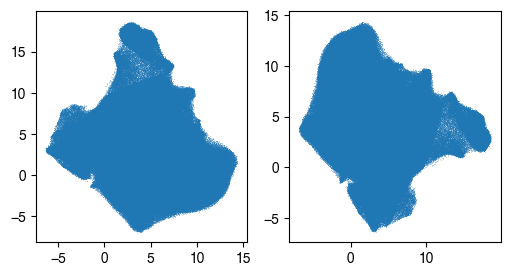

In [4]:
tfig, taxs = plt.subplots(1, 2, figsize=(6,3))

taxs[0].scatter(*umap_embedding.T, s=0.1, linewidths=0)
trans_umap_embedding = O2_transform(
    umap_embedding.T, 
    alpha=np.pi/2,
    reflection=True
).T
taxs[1].scatter(*trans_umap_embedding.T, s=0.1, linewidths=0)

umap_embedding = trans_umap_embedding

### Panel A contains a flowchart
We create this separately with `latex` and `tikz`.
It would be nice to include this as a vector graphics here, but I can't figure out how to do that.
The flowchart is added manually in Inkscape.

In [5]:
ax = fig.add_subplot(gs[:2, :4])

ax.text(0.5, 0.5, "[INSERT FLOWCHART HERE]", fontsize='xx-large', va='center', ha='center')
ax.axis('off')

ax.text(labx, laby, "A", fontsize='xx-large', transform=ax.transAxes);

### Panel B contains the heatmap 

with MFI for each T cell population.

In [6]:
# heatmap of marker expression per population

ax = fig.add_subplot(gs[:2, 4:6])

ax_ins = ax.inset_axes([0.28, 0.2, 0.72, 0.8], transform=ax.transAxes)
ax.axis('off')
fancy_celltype_names = [fancy_names[name] for name in celltype_names]
plots.simple_heatmap(ax_ins, MFI[::-1,:], sel_markers, fancy_celltype_names[::-1])

for i, tick in enumerate(ax_ins.get_yticklabels()):
    tick.set_rotation(45)
    name = celltype_names[::-1][i]
    tick.set_color(celltype_color_dict[name])

ax.text(labx, laby, "B", fontsize='xx-large', transform=ax.transAxes);

### Panel C shows a UMAP of the data 
with the location of the clusters. We manually set locations of labels.

In [7]:
# UMAP with clusters

ax = fig.add_subplot(gs[:2, 6:8])

celltype_color_per_sample = np.array([celltype_color_dict[c] for c in celltype_per_sample])
rperm = np.random.choice((n := umap_embedding.shape[0]), n, replace=False)
ax.scatter(
    umap_embedding[rperm,0], umap_embedding[rperm,1], 
    c=celltype_color_per_sample[rperm], s=0.1, rasterized=True,
    linewidths=0
)

# find means of clusters for annotation

clus_means = utils.get_mean_per_cluster(umap_embedding, celltype_per_sample, celltype_names)


## positions for the sub labels
position = {
    "69 SP TRM"    : (-3, 0),
    "CX3CR1hi TEM" : (14, 11),
    "Eff"          : (0, -5),
    "DP TRM"       : (-5.0, 13),
    "TEM"          : (14, 0),
    "103 SP TRM"   : (7.0, 13),
    "DN TRM"       : (12, -2)
}

for z, name in zip(clus_means, celltype_names):
    pos = position.get(name, z)
    fancy_name = fancy_names[name]
    ap = dict(arrowstyle="->") if name in position else None
    ax.annotate(
        fancy_name, xy=z, xytext = pos, 
        va='center', ha='center',
        fontsize='small',
        arrowprops=ap
    )
    print(name, pos)

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_xticks([])
ax.set_yticks([])

ax.text(labx, laby, "C", fontsize='xx-large', transform=ax.transAxes);

DP TRM (-5.0, 13)
69 SP TRM (-3, 0)
103 SP TRM (7.0, 13)
DN TRM (12, -2)
TEM (14, 0)
CX3CR1hi TEM (14, 11)
TCM [14.99083821  3.56848519]
Eff (0, -5)


### Panel D has 8 sub-panels showing a timeseries of UMAPs

The UMAPs show the density of cells

In [8]:
# create one one panel per day

uday = np.sort(np.unique(sample_day))

axs = []
ax = None
for i in range(len(uday)):
    ax = fig.add_subplot(gs[2, i], sharex=ax, sharey=ax)
    axs.append(ax)
    
    
for i, d in enumerate(uday):
    select = sample_day == d
    zs = umap_embedding[select, :]
    ax = axs[i]
    
    ran_idxs = np.random.choice(range(zs.shape[0]), 1000)
    umap_density = sts.gaussian_kde(zs[ran_idxs,:].T)(zs.T)

    ax.scatter(
        zs[:,0], zs[:,1], 
        c=umap_density, s=0.1, rasterized=True, linewidths=0
    )
    
    ax.set_xlabel("UMAP 1")
    if i == 0:
        ax.set_ylabel("UMAP 2")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{d} DPI")
    
Ax = fig.add_subplot(gs[2, :4])

Ax.axis('off')
Ax.text(labx, laby, "D", fontsize='xx-large', transform=Ax.transAxes);

### Panel E has subpanels for each cluster

For each cluster we show the timeseries of the relative frequency.

In [9]:
axs = []
ax = None
num_cols = 4
for i in range(len(celltype_names)):
    a, b = divmod(i, num_cols)
    ax = fig.add_subplot(gs[3+a, 2*b:2*(b+1)], sharex=ax, sharey=ax)
    axs.append(ax)
    
## plot cluster freqs
sorted_mice = sorted(list(freq_df), key=lambda x: (mouse_day_dict[x], str(x)))
days = [mouse_day_dict[m] for m in sorted_mice]
xticks = [14, 28, 42, 56]
plot_data_dict = {}
for i, ct in enumerate(celltype_names):
    fancy_name = fancy_names[ct]
    col = celltype_color_dict[ct]
    ax = axs[i]
    qs = freq_df[sorted_mice].loc[ct]
    ax.scatter(days, qs, s=10, color=col)
    udays = np.unique(days)
    grouped_qs = [[q for t, q in zip(days, qs) if t == d] for d in udays]
    def nonzero(xs):
        return [x for x in xs if x != 0]
    mean_qs = [sts.gmean(nonzero(q)) for q in grouped_qs]
    ax.plot(udays, mean_qs, color=col)
    ax.set_title(fancy_name, color=col)
    ax.set_yscale('log')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    # remove yticks
    a, b = divmod(i, num_cols)
    if b > 0:
        for tl in ax.axes.get_yticklabels():
            tl.set_visible(False)
    else:
        ax.set_ylabel("Fraction of cells")
    if a+1 == len(celltype_names) // num_cols:
        ax.set_xlabel("DPI")
    # save plottable data in a dict for additional inset axes
    plot_data_dict[ct] = {"days" : days, "qs" : qs, "udays" : udays, "mean_qs" : mean_qs}


# add inset for DN TRM
def add_inset(ct):
    sel_ax = axs[celltype_names.index(ct)]
    ins_ax = sel_ax.inset_axes([0.4, 0.5, 0.55, 0.4], transform=sel_ax.transAxes)
    dd = plot_data_dict[ct]
    col = celltype_color_dict[ct]
    ins_ax.plot(dd["udays"], dd["mean_qs"], color=col)
    ins_ax.scatter(dd["days"], dd["qs"], s=10, color=col)
    ins_ax.set_yscale("log")
    ins_ax.set_xticks(xticks)


add_inset("DN TRM")

axs[0].set_ylim(4e-3,8e-1)


Ax = fig.add_subplot(gs[3, :4])

Ax.axis('off')
Ax.text(labx, laby, "E", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.05, 1.05, 'E')

### Now we can finally have a look at the figure

minus the flowchart

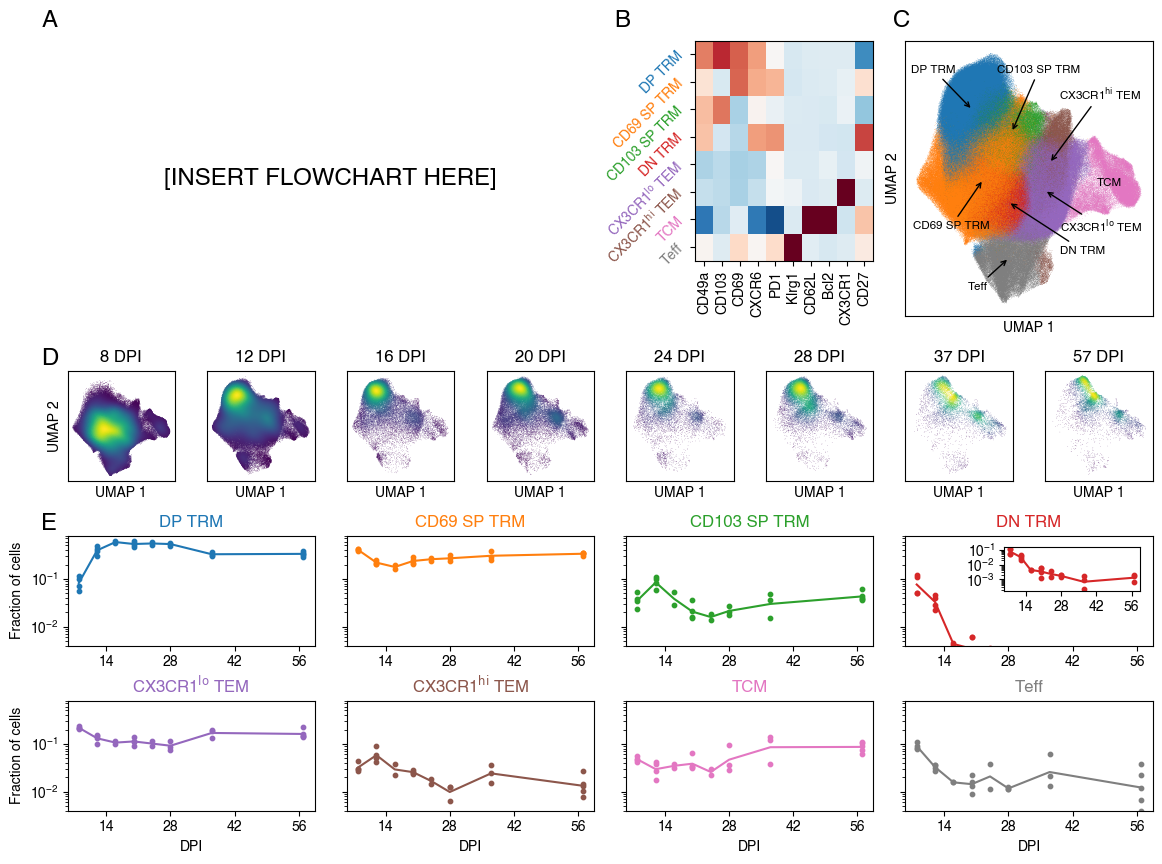

In [10]:
fig

In [11]:
#fig.savefig("../results/FigureSAClusteringCD8.pdf", bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
